In [870]:
import pennylane as qml
from pennylane import numpy as np
from IPython.display import display, Latex

# from numba import jit

# numpy 
import numpy as np_
import scipy as sp

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires= 2)
# dev_new = qml.device('default.qubit', wires=2)

# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [871]:
Tau_global, Phi_global = np.zeros(3), 0
Gamma_ps_global = 0

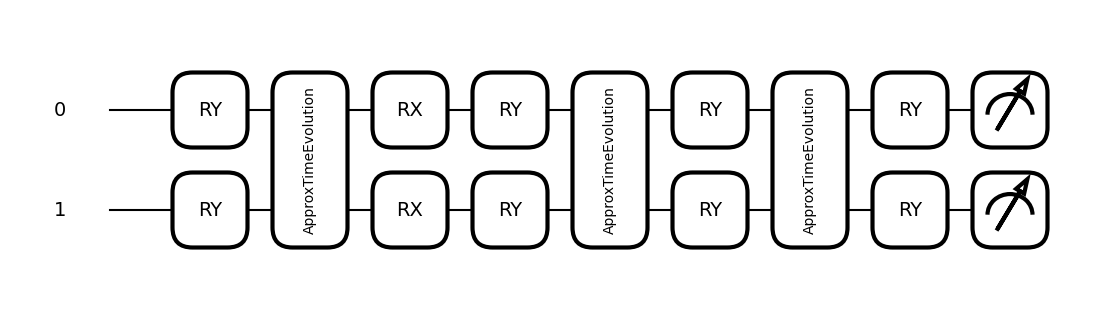

In [872]:
# 1-layer
@qml.qnode(dev)
def circuit_alt(phi_in):
    global Tau_global, Phi_global
    
    theta_init, tau_1, tau_2 = np.array([np.pi/4, np.pi/2, np.pi/2])
    phi = phi_in
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, -tau_1/2, 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, -tau_2/2, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(hamiltonian, -phi/2, 1)
    
    # qml.RX(np.pi/2, wires=0)
    # qml.RX(np.pi/2, wires=1)
    
    qml.RY(-np.pi/2, wires=0)
    qml.RY(-np.pi/2, wires=1)
    
    return qml.density_matrix(wires=[0, 1])

fig, ax = qml.draw_mpl(circuit_alt)(0)

In [873]:
type(circuit_alt(np.pi))

pennylane.numpy.tensor.tensor

In [874]:
rho = np.zeros((2 ** 2, 2 ** 2), dtype=np.complex128)

type(rho)

pennylane.numpy.tensor.tensor

In [875]:
@qml.qnode(dev)
def Post_selection_alt(phi):
    global Gamma_ps_global
    Gamma_ps = Gamma_ps_global
        
    # Get density matrix from circuit_2
    density_matrix = np.zeros((4, 4), dtype=np.complex128)
    density_matrix = circuit_alt(phi)
    
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    K_H = K.conj().T
    
    Numerator = sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H)
    Denominator = np.trace(sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H))
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=[0, 1])
    
    return qml.density_matrix(wires=[0, 1])

In [876]:
Post_selection_alt(np.pi)

array([[ 5.00000000e-01+8.47409176e-33j,  2.08166817e-16-1.11022302e-16j,
         2.63677968e-16-4.16333634e-17j, -5.00000000e-01-1.11022302e-16j],
       [ 2.49800181e-16+5.55111512e-17j,  2.77555756e-17+1.12757026e-17j,
        -2.77555756e-17+1.47451495e-17j, -2.49800181e-16-9.71445147e-17j],
       [ 2.63677968e-16+1.11022302e-16j, -5.55111512e-17-1.47451495e-17j,
        -2.77555756e-17-1.12757026e-17j, -2.91433544e-16-1.11022302e-16j],
       [-5.00000000e-01+1.11022302e-16j, -1.80411242e-16+1.38777878e-16j,
        -2.35922393e-16+1.11022302e-16j,  5.00000000e-01-7.70371978e-33j]])

In [877]:
# @qml.qnode(dev_new)
# def circuit_after(phi_input):
#     Post_selection_alt(phi_input)
    
#     qml.qubit
    
#     return qml.density_matrix(wires=[0, 1])

# Gamma_ps_global = 0.7
# circuit_after(np.pi)

In [878]:
def Sweep(Sweep_bound, Gamma_ps_in):
    
    PHI = np.arange(Sweep_bound[0], Sweep_bound[1], Sweep_bound[2]).reshape(-1, 1)
    
    Data = np.zeros((len(PHI), 1 + len(Gamma_ps_in)))
    Data[:, 0] = PHI.squeeze()
    
    GAMMA_INDEX_IN_DATA = 1
    
    global Gamma_ps_global
    
    for Gamma_index in range(len(Gamma_ps_in)):
        Gamma_ps_global = Gamma_ps_in[Gamma_index]
        
        for i in range(len(PHI)):
            Data[i][Gamma_index + GAMMA_INDEX_IN_DATA] = qml.qinfo.classical_fisher(Post_selection_alt)(PHI[i])
        
    return Data

In [879]:
Sweep_data = np_.array([1e-4, np.pi * 3 + 1e-4, np.pi/(25*2)])
Gamma_ps_desired = 0.3, 0.4, 0.7, 0.8

Result = Sweep(Sweep_data, Gamma_ps_desired)

print(Result)

[[1.00000000e-04 3.81427388e+04 2.60541628e+04 9.16206777e+03
  5.79100390e+03]
 [6.29318531e-02 6.63231265e+01 4.20241484e+01 1.52564060e+01
  1.12281816e+01]
 [1.25763706e-01 1.40344549e-17 1.24237030e-17 9.17494752e-18
  6.74623332e-18]
 [1.88595559e-01 4.60681217e-18 6.20672727e-18 3.28296065e-18
  3.23345747e-18]
 [2.51427412e-01 4.76508155e+01 2.86658811e+01 5.47820803e+00
  8.34663778e+00]
 [3.14259265e-01 1.12557469e-17 8.28784476e-18 3.86122616e-18
  6.03126831e-18]
 [3.77091118e-01 6.69547696e-18 5.54289854e-18 5.21292628e-18
  6.96544370e-18]
 [4.39922972e-01 2.63866848e-18 2.48066281e-18 2.56467095e-18
  1.82876533e-18]
 [5.02754825e-01 1.39580063e+00 3.51285202e-01 3.29985529e-02
  2.09484737e-01]
 [5.65586678e-01 7.56946695e-02 1.19792635e+00 1.38679918e-01
  1.04316299e-01]
 [6.28418531e-01 2.33446589e-19 2.25923679e-20 8.85828350e-19
  4.36996566e-19]
 [6.91250384e-01 4.26578129e-01 1.38644350e-01 1.81374130e-02
  1.52309864e-01]
 [7.54082237e-01 4.24899372e-02 1.990275

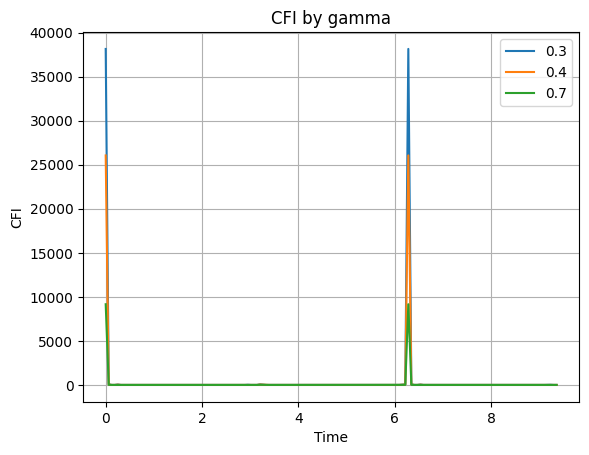

In [880]:
plt.plot(Result[:,0], Result[:,1], label = 0.3)
plt.plot(Result[:,0], Result[:,2], label = 0.4)
plt.plot(Result[:,0], Result[:,3], label = 0.7)
# plt.plot(Result[:,0], Result[:,4], label = 0.8)

plt.title('CFI by gamma')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

In [881]:
import random

array = np_.zeros(4)

array[:4] = random.uniform(0,1)

array = np_.round(array, 3)
array = np.array(array)

array

tensor([0.028, 0.028, 0.028, 0.028], requires_grad=True)

In [882]:
Sweep_data = np_.array([1e-4, np.pi * 3 + 1e-4, np.pi/(25*2)])
Gamma_ps_desired = 0.6, 0.7

Result = Sweep(Sweep_data, Gamma_ps_desired)

# print(Result)

# Result[:,0]

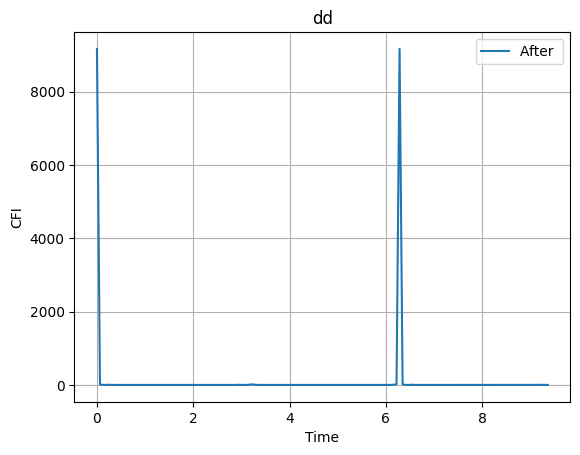

In [883]:
plt.plot(Result[:, 0], Result[:, 2], label = 'After ')
    
plt.title('dd')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

In [884]:
gamma_desired = 0.3, 0.4, 0.6, 0.7
Data_Set = 

SyntaxError: invalid syntax (2349037780.py, line 2)